# This notebook transforms files as follows:
* takes input:
    - 2630_TAZ_POLY_only.shp
    - statisticalareas_demography2017.shp
    - Pop_Sex_Age_Religion - edited.xlsx
    - statisticalareas_demography2017.xlsx
    - religion_with_orthodox.csv
    - pop2taz.xlsx
* brings output:
    - taz2stat_area_coverage.csv
    - religion2taz.csv

# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import datetime
from scipy import optimize
import os
import geopandas as gpd
from geopandas import GeoSeries
%matplotlib inline

# Reading Data

## Matching taz to statCell

In [2]:
taz2stat_cell = pd.read_excel('../Data/GIS/statisticalareas_demography2017.cpg/CBS_Tahbura_Join_T.xlsx')

In [3]:
taz2stat_cell

ID Tahbura                                     City Tahbura   \
0            544                                       ראשון לציון   
1           2172                                             טבריה   
2           1186                                           ירושלים   
3            137                                           הרצלייה   
4           1828                                         קריית אתא   
...          ...                                               ...   
2544        2449                                               ערד   
2545        2593  נווה זוהר ים המלח - בתי מלון מפעלי ים המלח(סדום)   
2546        2552                          יישובים בדואים לא מוכרים   
2547         905                                         בני עטרות   
2548         906                                   התעשיה האווירית   

                                          STAS Tahbura  \
0                 ראשון לציון: אזורים סטטיסטים 412 413   
1                              טבריה: אזור סטטיסטי  11   
2                   ירושלים: אזורים סטטיסטים 1 31 1 34   
3                       הרצלייה: אזורים סטטיסטים 32 33   
4                          קריית אתא: אזור סטטיסטי  12   
...                                                ...   
2544                                  ערד: אזור תעשייה   
2545  נווה זוהר ים המלח - בתי מלון מפעלי ים המלח(סדום)   
2546                          יישובים בדואים לא מוכרים   
2547                                         בני עטרות   
2548                                   התעשיה האווירית   

                                             2630 מור_8         TYPE Tahbura  \
0                                        STREET Tahbura               מגורים   
1                                דוד רמז (שיכון עובדים)               מגורים   
2                      בית חנינא (דרום-מזרח), תל אל פול               מגורים   
3     קהילת ציון, בן יהודה, בן גוריון, אוסישקין, ארל...               מגורים   
4                                              שטח פתוח             שטח פתוח   
...                                                 ...                  ...   
2544                                אזור תעשייה אשת לוט         תעשיה +כרייה   
2545   נווה זוהר ים המלח - בתי מלון מפעלי ים המלח(סדום)  מגורים+תיירות+תעשיה   
2546                           יישובים בדואים לא מוכרים             שטח פתוח   
2547                                                NaN               מגורים   
2548                                    התעשיה האווירית                תעשיה   

      SEMEL_YISH cbs Stat11_Uni cbs  Pop_Total cbs  SHAPE_Leng cbs  \
0               8300            413         4565.0      1712.77420   
1               6700             11         6262.0      7337.67995   
2               3000           1032         3913.0      2626.45260   
3               6400             35         3917.0      2471.43633   
4               6800             12         4336.0     12258.92198   
...              ...            ...            ...             ...   
2544            5551            NaN            NaN    397630.55676   
2545           99999            NaN            NaN    132778.00688   
2546            5551            NaN            NaN    397630.55676   
2547             448              1          972.0      5525.47823   
2548            1746            NaN            NaN      3367.40996   

      SHAPE_Area cbs  Fid cbs  
0       1.675184e+05     2918  
1       1.505318e+06     2370  
2       2.252002e+05     2478  
3       2.431480e+05     2270  
4       4.425136e+06     2653  
...              ...      ...  
2544    1.291684e+09      946  
2545    2.664285e+08        2  
2546    1.291684e+09      946  
2547    1.296455e+06      823  
2548    7.220537e+05     1051  

[2549 rows x 11 columns]

In [4]:
taz2stat_cell = taz2stat_cell[['ID Tahbura', 'SEMEL_YISH cbs', 'Stat11_Uni cbs']]

In [5]:
taz2stat_cell.columns = ['taz_id', 'yesh_id', 'stat11_id']

## stat geometry

In [6]:
stat_cell = gpd.read_file('../Data/GIS/statisticalareas_demography2017.cpg/statisticalareas_demography2017.shp')

In [7]:
stat_cell.columns

Index(['SEMEL_YISH', 'STAT11', 'YISHUV_STA', 'SHEM_YISHU', 'SHEM_YIS_E',
       'Stat11_Uni', 'Stat11_Ref', 'Main_Fun_C', 'Main_Fun_T', 'Religi_y_C',
       'Religi_y_T', 'Religi_S_C', 'Religi_S_T', 'Pop_Total', 'Male_Total',
       'Female_Tot', 'age_0_14', 'age_15_19', 'age_20_29', 'age_30_64',
       'age_65_up', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [8]:
stat_cell.iloc[3000]

SEMEL_YISH                                                 8500
STAT11                                                       22
YISHUV_STA                                             85000022
SHEM_YISHU                                                 רמלה
SHEM_YIS_E                                                RAMLA
Stat11_Uni                                                   22
Stat11_Ref                                                 None
Main_Fun_C                                                    1
Main_Fun_T                                               מגורים
Religi_y_C                                                    4
Religi_y_T                                                מעורב
Religi_S_C                                                    1
Religi_S_T                                                יהודי
Pop_Total                                                  3746
Male_Total                                                 1923
Female_Tot                              

In [9]:
stat_cell = stat_cell[['SEMEL_YISH', 'STAT11', 'geometry']]

In [10]:
import fiona.crs
stat_cell = stat_cell.to_crs(fiona.crs.from_epsg(4326))

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
stat_cell.columns = ['yesh_id', 'stat11_id', 'geometry']

## taz geometry

In [12]:
taz = gpd.read_file('../Data/GIS/2630_TAZ_POLY_only/2630_TAZ_POLY_only.shp')

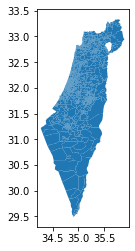

In [13]:
taz.plot()

In [14]:
taz = taz[['ID', 'geometry']]
taz.columns = ['taz_id', 'geometry']

# matching precentage of overlap

In [15]:
overlap = gpd.overlay(taz, stat_cell, how='intersection')

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\base.py:48: UserWarning: GeoSeries crs mismatch: epsg:4326 and +init=epsg:4326 +no_defs +type=crs
  warn("GeoSeries crs mismatch: {0} and {1}".format(this.crs, other.crs))


In [16]:
result = overlap.apply(lambda row: (row['geometry'].area) / float(taz[taz['taz_id']==row['taz_id']]['geometry'].area), axis=1)

In [17]:
overlap['prc'] = result

In [18]:
overlap.sort_values(by='taz_id')

taz_id  yesh_id  stat11_id  \
12469       1     1333          1   
363         1     5526       5526   
3218        1     1200         34   
444         1     5530       5530   
2198        1     1200         32   
...       ...      ...        ...   
13967    2630      246          4   
4489     2630     5539       5539   
13907    2630      665          1   
13901    2630      246          6   
4475     2630      246          8   

                                                geometry       prc  
12469  POLYGON ((34.98876 31.86543, 34.98867 31.86536...  0.057999  
363    MULTIPOLYGON (((34.99818 31.85364, 34.99625 31...  0.000832  
3218   MULTIPOLYGON (((35.03481 31.86706, 35.03555 31...  0.002017  
444    POLYGON ((34.97562 31.86513, 34.97586 31.86546...  0.188841  
2198   MULTIPOLYGON (((34.98206 31.87782, 34.98212 31...  0.000101  
...                                                  ...       ...  
13967  MULTIPOLYGON (((34.58962 31.41531, 34.58962 31...  0.000581  
4489   MULTIPOLYGON (((34.59065 31.41422, 34.59079 31...  0.015989  
13907  POLYGON ((34.57452 31.44342, 34.57471 31.44364...  0.001257  
13901  POLYGON ((34.58725 31.43494, 34.58652 31.43382...  0.713878  
4475   POLYGON ((34.58651 31.41858, 34.58787 31.41715...  0.134354  

[13986 rows x 5 columns]

In [19]:
overlap = overlap[['taz_id', 'yesh_id', 'stat11_id', 'prc']]
overlap

taz_id  yesh_id  stat11_id       prc
0         544     8300        423  0.000239
1         546     8300        423  0.004758
2         547     8300        423  0.979695
3         548     8300        423  0.010024
4         544     8300        421  0.000081
...       ...      ...        ...       ...
13981    2593     1775          1  0.007545
13982    2593     1057          1  0.000337
13983    2593     1772          1  0.000955
13984    2593     9974       9974  0.000429
13985    2552     9974       9974  0.083111

[13986 rows x 4 columns]

In [20]:
overlap = overlap.sort_values(by='taz_id')

In [21]:
overlap.reset_index(inplace=True)

In [22]:
overlap = overlap.iloc[:,1:]

In [23]:
overlap = overlap.sort_values(by='stat11_id').sort_values(by='yesh_id').sort_values(by='taz_id')
overlap

taz_id  yesh_id  stat11_id       prc
2           1     1200         34  0.002017
3           1     5530       5530  0.188841
1           1     5526       5526  0.000832
5           1      856          1  0.068471
6           1     9967       9967  0.675029
...       ...      ...        ...       ...
13981    2630      246          4  0.000581
13982    2630     5539       5539  0.015989
13983    2630      665          1  0.001257
13985    2630      246          8  0.134354
13979    2630      246          5  0.001886

[13986 rows x 4 columns]

In [24]:
overlap.loc[overlap['yesh_id']==99999,'yesh_id'] = 9
overlap = overlap.sort_values(by='yesh_id')
overlap

taz_id  yesh_id  stat11_id       prc
13912    2617        7          1  0.090405
13731    2593        9       9999  0.238538
13925    2618        9       9999  0.002769
13787    2601        9       9999  0.086299
13783    2600        9       9999  0.214792
...       ...      ...        ...       ...
13738    2593     9974       9974  0.000429
13390    2552     9974       9974  0.083111
7286     1319     9975       9975  0.001783
7911     1553     9975       9975  0.022473
7278     1318     9975       9975  0.005314

[13986 rows x 4 columns]

In [25]:
def creat_joint_id(row):
    if row['yesh_id'] == row['stat11_id']:
        return str(int(row['yesh_id']))
    fill =  4 - len(str(int(row['stat11_id'])))
    stat11_str = '0'*fill + str(int(row['stat11_id']))
    return int(str(int(row['yesh_id'])) + stat11_str)


In [26]:
def creat_joint_cahana(row):
     return int(str(row['yesh_id']) + str(row['stat11_id']))

In [27]:
overlap['yesh_stat11_id'] = overlap.apply(creat_joint_id, axis=1)

In [28]:
overlap['cahana_id'] = overlap.apply(creat_joint_cahana, axis=1)

In [29]:
overlap.sort_values(by='yesh_id')

taz_id  yesh_id  stat11_id       prc yesh_stat11_id  cahana_id
13912    2617        7          1  0.090405          70001         71
13731    2593        9       9999  0.238538          99999      99999
13925    2618        9       9999  0.002769          99999      99999
13787    2601        9       9999  0.086299          99999      99999
13783    2600        9       9999  0.214792          99999      99999
...       ...      ...        ...       ...            ...        ...
13738    2593     9974       9974  0.000429           9974   99749974
13390    2552     9974       9974  0.083111           9974   99749974
7911     1553     9975       9975  0.022473           9975   99759975
7286     1319     9975       9975  0.001783           9975   99759975
7278     1318     9975       9975  0.005314           9975   99759975

[13986 rows x 6 columns]

In [30]:
overlap.to_csv('../Data/raw/overlap_taz2stat.csv')

# Generate stat_cell religion info

## merge stat_cell with pop religion cahana

In [407]:
pd.set_option('display.max_rows', 20)
stat_cell

yesh_id  stat11_id                                           geometry
0           7          1  POLYGON ((34.71997 31.61232, 34.71991 31.61240...
1       99999       9999  MULTIPOLYGON (((35.36591 31.23465, 35.36613 31...
2          10          1  POLYGON ((34.88230 31.74653, 34.88224 31.74663...
3          11          1  POLYGON ((34.71997 31.61232, 34.71794 31.61144...
4          13          1  POLYGON ((35.28430 30.76343, 35.28362 30.76156...
...       ...        ...                                                ...
3192     9600         25  POLYGON ((35.06452 32.85480, 35.06605 32.85432...
3193     9600         31  POLYGON ((35.06113 32.84791, 35.06118 32.84791...
3194     9600         32  POLYGON ((35.06044 32.84216, 35.05951 32.84257...
3195     9600         33  POLYGON ((35.06055 32.84211, 35.06100 32.84189...
3196     9600         34  POLYGON ((35.06646 32.83800, 35.06567 32.83653...

[3197 rows x 3 columns]

In [408]:
stat_cell.loc[stat_cell['yesh_id']==99999,'yesh_id'] = 9
stat_cell = stat_cell.sort_values(by='yesh_id')
stat_cell = stat_cell.iloc[:,:-1]
stat_cell

yesh_id  stat11_id
0          7          1
1          9       9999
2         10          1
3         11          1
4         13          1
..       ...        ...
146     9971       9971
147     9972       9972
148     9973       9973
149     9974       9974
150     9975       9975

[3197 rows x 2 columns]

In [409]:
stat_cell['yesh_stat11_id'] = stat_cell.apply(creat_joint_id, axis=1)
stat_cell['cahana_id'] = stat_cell.apply(creat_joint_cahana, axis=1)
stat_cell

yesh_id  stat11_id yesh_stat11_id  cahana_id
0          7          1          70001         71
1          9       9999          99999      99999
2         10          1         100001        101
3         11          1         110001        111
4         13          1         130001        131
..       ...        ...            ...        ...
146     9971       9971           9971   99719971
147     9972       9972           9972   99729972
148     9973       9973           9973   99739973
149     9974       9974           9974   99749974
150     9975       9975           9975   99759975

[3197 rows x 4 columns]

In [410]:
cahana = pd.read_csv('../Data/GIS/statisticalareas_demography2017.cpg/religion_with_orthodox.csv')

In [411]:
cahana = cahana.iloc[:,:-1]
cahana.columns = ['cahana_id', 'Orth', 'Jewish', 'Muslim', 'Christian', 'Druze', 'Other']
cahana

cahana_id   Orth  Jewish  Muslim  Christian  Druze  Other
0           261  0.015   0.985       0          0      0      0
1           281  0.009   0.991       0          0      0      0
2           311  0.015   0.985       0          0      0      0
3           312  0.010   0.990       0          0      0      0
4           313  0.020   0.980       0          0      0      0
...         ...    ...     ...     ...        ...    ...    ...
1334   30001631  0.022   0.978       0          0      0      0
1335   30001632  0.031   0.969       0          0      0      0
1336   30001633  0.013   0.987       0          0      0      0
1337   30001634  0.045   0.955       0          0      0      0
1338   30001642  0.040   0.960       0          0      0      0

[1339 rows x 7 columns]

In [412]:
outer = stat_cell.merge(cahana, on='cahana_id', how='left')
outer.sort_values(by='cahana_id')

yesh_id  stat11_id yesh_stat11_id  cahana_id  Orth  Jewish  Muslim  \
0           7          1          70001         71   NaN     NaN     NaN   
2          10          1         100001        101   NaN     NaN     NaN   
3          11          1         110001        111   NaN     NaN     NaN   
4          13          1         130001        131   NaN     NaN     NaN   
5          15          1         150001        151   NaN     NaN     NaN   
...       ...        ...            ...        ...   ...     ...     ...   
3192     9971       9971           9971   99719971   NaN     NaN     NaN   
3193     9972       9972           9972   99729972   NaN     NaN     NaN   
3194     9973       9973           9973   99739973   NaN     NaN     NaN   
3195     9974       9974           9974   99749974   NaN     NaN     NaN   
3196     9975       9975           9975   99759975   NaN     NaN     NaN   

      Christian  Druze  Other  
0           NaN    NaN    NaN  
2           NaN    NaN    NaN  
3           NaN    NaN    NaN  
4           NaN    NaN    NaN  
5           NaN    NaN    NaN  
...         ...    ...    ...  
3192        NaN    NaN    NaN  
3193        NaN    NaN    NaN  
3194        NaN    NaN    NaN  
3195        NaN    NaN    NaN  
3196        NaN    NaN    NaN  

[3197 rows x 10 columns]

In [413]:
len(outer[outer['Other'].isna()][['yesh_id', 'stat11_id']])

1882

In [414]:
outer = outer[['yesh_id', 'stat11_id', 'yesh_stat11_id', 'Orth', 'Jewish', 'Muslim', 'Christian', 'Druze', 'Other']]

In [415]:
pd.set_option('display.max_rows', 20)
outer

yesh_id  stat11_id yesh_stat11_id  Orth  Jewish  Muslim  Christian  \
0           7          1          70001   NaN     NaN     NaN        NaN   
1           9       9999          99999   NaN     NaN     NaN        NaN   
2          10          1         100001   NaN     NaN     NaN        NaN   
3          11          1         110001   NaN     NaN     NaN        NaN   
4          13          1         130001   NaN     NaN     NaN        NaN   
...       ...        ...            ...   ...     ...     ...        ...   
3192     9971       9971           9971   NaN     NaN     NaN        NaN   
3193     9972       9972           9972   NaN     NaN     NaN        NaN   
3194     9973       9973           9973   NaN     NaN     NaN        NaN   
3195     9974       9974           9974   NaN     NaN     NaN        NaN   
3196     9975       9975           9975   NaN     NaN     NaN        NaN   

      Druze  Other  
0       NaN    NaN  
1       NaN    NaN  
2       NaN    NaN  
3       NaN    NaN  
4       NaN    NaN  
...     ...    ...  
3192    NaN    NaN  
3193    NaN    NaN  
3194    NaN    NaN  
3195    NaN    NaN  
3196    NaN    NaN  

[3197 rows x 9 columns]

## merge stat_cell info with pop table

In [290]:
pop = pd.read_excel('../Data/GIS/statisticalareas_demography2017.cpg/Pop_Sex_Age_Religion - edited.xlsx')

In [291]:
pd.set_option('display.max_rows', None)
pop.iloc[10]

OBJECTID                                10
Shape                                  NaN
SEMEL_YISHUV                            23
STAT08                                   1
YISHUV_STAT08                       230001
Shem_Yishuv                          אמציה
Shem_Yishuv_English                 AMAZYA
Stat08_Unite                           NaN
Main_Function_Code                       1
Main_Function_Txt                   מגורים
order_                                 NaN
LocNameHeb                           אמציה
Quarter                                NaN
SubQuarter                             NaN
StatAreaCmb                            NaN
StatArea                                 1
LocalityCode                            23
locality_stat                       230001
EstbYr                                1955
DistrictCode                             6
DistrictHeb                     מחוז הדרום
SubDistrictCode                         61
SubDistrictHeb                  נפת אשקלון
NatRegCode 

In [292]:
pd.set_option('display.max_rows', 20)

In [293]:
pop = pop[['SEMEL_YISHUV' ,'YISHUV_STAT08', 'religion', 'ReligionHeb', 'religion_pcnt', 'Shem_Yishuv']]

In [294]:
pop = pop[~pop['YISHUV_STAT08'].isna()]

In [295]:
pop['religion'].isna().sum()

265

In [297]:
pd.set_option('display.max_rows', None)
missing = pop[pop['religion'].isna()]

In [298]:
exist = pop[~pop['religion'].isna()]
exist

SEMEL_YISHUV  YISHUV_STAT08  religion ReligionHeb  religion_pcnt  \
1                7        70001.0       1.0      יהודים           99.6   
2               10       100001.0       1.0      יהודים          100.0   
3               11       110001.0       1.0      יהודים           98.7   
4               13       130001.0       1.0      יהודים           97.6   
5               15       150001.0       1.0      יהודים           98.3   
6               16       160001.0       1.0      יהודים           96.4   
7               18       180001.0       1.0      יהודים           96.9   
8               21       210001.0       1.0      יהודים           95.8   
9               22       220001.0       1.0      יהודים           91.9   
10              23       230001.0       1.0      יהודים           99.1   
11              24       240001.0       1.0      יהודים           99.7   
12              26       260001.0       1.0      יהודים           97.9   
13              27       270001.0       1.0      יהודים          100.0   
14              28       280001.0       1.0      יהודים           98.9   
15              29       290001.0       1.0      יהודים           98.6   
16              31       310001.0       1.0      יהודים           88.7   
17              31       310002.0       1.0      יהודים           93.7   
18              31       310003.0       1.0      יהודים           92.4   
19              31       310004.0       1.0      יהודים           97.1   
21              31       310006.0       1.0      יהודים           97.8   
22              31       310007.0       1.0      יהודים           86.3   
23              32       320001.0       1.0      יהודים           99.5   
24              33       330001.0       1.0      יהודים           98.7   
25              35       350001.0       1.0      יהודים           88.9   
26              36       360001.0       1.0      יהודים           99.5   
27              37       370001.0       1.0      יהודים          100.0   
28              39       390001.0       1.0      יהודים           99.7   
29              41       410001.0       1.0      יהודים           99.1   
30              43       430001.0       1.0      יהודים           94.1   
31              44       440001.0       1.0      יהודים           99.7   
32              46       460001.0       1.0      יהודים           99.1   
33              47       470001.0       1.0      יהודים           98.6   
34              48       480001.0       1.0      יהודים           98.1   
35              49       490001.0       1.0      יהודים           95.5   
36              52       520001.0       1.0      יהודים           99.7   
37              53       530001.0       1.0      יהודים           96.9   
38              55       550001.0       1.0      יהודים           99.6   
39              57       570001.0       1.0      יהודים           96.3   
40              58       580001.0       1.0      יהודים           98.8   
41              59       590001.0       1.0      יהודים          100.0   
42              62       620001.0       1.0      יהודים           97.8   
43              63       630001.0       1.0      יהודים           96.8   
44              64       640001.0       1.0      יהודים           99.2   
45              65       650001.0       1.0      יהודים           94.0   
46              66       660001.0       1.0      יהודים           82.6   
47              67       670001.0       1.0      יהודים           94.4   
48              69       690001.0       1.0      יהודים           97.4   
53              70       700122.0       1.0      יהודים           81.8   
54              70       700123.0       1.0      יהודים           84.7   
56              70       700125.0       1.0      יהודים           83.4   
57              70       700126.0       1.0      יהודים           83.9   
58              70       700131.0       1.0      יהודים           82.6   
59              70       700132.0       1.0      יהודים           82.7   
60        

In [299]:
# use pd.concat to join the new columns with your original dataframe
exist = pd.concat([exist,pd.get_dummies(exist['ReligionHeb'], prefix='דת')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
exist.drop(['religion', 'ReligionHeb'],axis=1, inplace=True)
exist

SEMEL_YISHUV  YISHUV_STAT08  religion_pcnt           Shem_Yishuv  \
1                7        70001.0           99.6                   שחר   
2               10       100001.0          100.0                 תירוש   
3               11       110001.0           98.7                ניר חן   
4               13       130001.0           97.6                  חצבה   
5               15       150001.0           98.3                  נועם   
6               16       160001.0           96.4               בית ניר   
7               18       180001.0           96.9               שדה משה   
8               21       210001.0           95.8              באר אורה   
9               22       220001.0           91.9           מקווה ישראל   
10              23       230001.0           99.1                 אמציה   
11              24       240001.0           99.7                  לכיש   
12              26       260001.0           97.9              ראש פינה   
13              27       270001.0          100.0             שדות מיכה   
14              28       280001.0           98.9            מזכרת בתיה   
15              29       290001.0           98.6            יסוד המעלה   
16              31       310001.0           88.7                אופקים   
17              31       310002.0           93.7                אופקים   
18              31       310003.0           92.4                אופקים   
19              31       310004.0           97.1                אופקים   
21              31       310006.0           97.8                אופקים   
22              31       310007.0           86.3                אופקים   
23              32       320001.0           99.5                  עוצם   
24              33       330001.0           98.7               בת שלמה   
25              35       350001.0           88.9                  גדות   
26              36       360001.0           99.5               שדה דוד   
27              37       370001.0          100.0                  איתן   
28              39       390001.0           99.7                   גפן   
29              41       410001.0           99.1                אליכין   
30              43       430001.0           94.1                 מטולה   
31              44       440001.0           99.7                  זוהר   
32              46       460001.0           99.1                 יבנאל   
33              47       470001.0           98.6              כפר תבור   
34              48       480001.0           98.1                מנחמיה   
35              49       490001.0           95.5               אילנייה   
36              52       520001.0           99.7                 לוזית   
37              53       530001.0           96.9                 עתלית   
38              55       550001.0           99.6                  נוגה   
39              57       570001.0           96.3          כנרת (קבוצה)   
40              58       580001.0           98.8                  מצפה   
41              59       590001.0          100.0                 נחושה   
42              62       620001.0           97.8              דגניה א'   
43              63       630001.0           96.8          כנרת (מושבה)   
44              64       640001.0           99.2               יד רמבם   
45              65       650001.0           94.0                  מגדל   
46              66       660001.0           82.6        מרחביה (קיבוץ)   
47              67       670001.0           94.4               אור הנר   
48              69       690001.0           97.4               ניר עוז   
53              70       700122.0           81.8                 אשדוד   
54              70       700123.0           84.7                 אשדוד   
56              70       700125.0           83.4                 אשדוד   
57              70       700126.0           83.9                 אשדוד   
58              70       700131.0           82.6                 אשדוד   
59              70       700132.0           82.7                 אשדוד   
60        

In [301]:
exist.columns = list(exist.columns[0:4]) + ['Druze', 'Other', 'Jewish', 'Muslim', 'Christian']

In [303]:
exist['religion_pcnt'] = exist['religion_pcnt']/100

In [452]:
exist

Druze  Other  Jewish  Muslim  Christian
YISHUV_STAT08                                         
70001            0.0    0.0   0.996   0.004        0.0
100001           0.0    0.0   1.000   0.000        0.0
110001           0.0    0.0   0.987   0.013        0.0
130001           0.0    0.0   0.976   0.024        0.0
150001           0.0    0.0   0.983   0.017        0.0
...              ...    ...     ...     ...        ...
97000033         0.0    0.0   0.991   0.009        0.0
98000001         0.0    0.0   0.989   0.011        0.0
98000002         0.0    0.0   0.991   0.009        0.0
98000003         0.0    0.0   0.985   0.015        0.0
98000004         0.0    0.0   0.990   0.010        0.0

[2765 rows x 5 columns]

In [330]:
relevent = ['Druze', 'Other', 'Jewish', 'Muslim', 'Christian']
def convert2mark(row):
    relevent = ['Druze', 'Other', 'Jewish', 'Muslim', 'Christian']
    row = row[relevent]
    row = row.sum(axis=0)
    return pd.Series([[1, 0][x == 0] for x in row[relevent]])
tot_pop_exist = exist.groupby(by='SEMEL_YISHUV').apply(convert2mark)
tot_pop_exist.columns = [x + y for x, y in zip(['t_']*(len(relevent)), relevent)]
tot_pop_exist

t_Druze  t_Other  t_Jewish  t_Muslim  t_Christian
SEMEL_YISHUV                                                   
7                   0        0         1         0            0
10                  0        0         1         0            0
11                  0        0         1         0            0
13                  0        0         1         0            0
15                  0        0         1         0            0
16                  0        0         1         0            0
18                  0        0         1         0            0
21                  0        0         1         0            0
22                  0        0         1         0            0
23                  0        0         1         0            0
24                  0        0         1         0            0
26                  0        0         1         0            0
27                  0        0         1         0            0
28                  0        0         1         0            0
29                  0        0         1         0            0
31                  0        0         1         0            0
32                  0        0         1         0            0
33                  0        0         1         0            0
35                  0        0         1         0            0
36                  0        0         1         0            0
37                  0        0         1         0            0
39                  0        0         1         0            0
41                  0        0         1         0            0
43                  0        0         1         0            0
44                  0        0         1         0            0
46                  0        0         1         0            0
47                  0        0         1         0            0
48                  0        0         1         0            0
49                  0        0         1         0            0
52                  0        0         1         0            0
53                  0        0         1         0            0
55                  0        0         1         0            0
57                  0        0         1         0            0
58                  0        0         1         0            0
59                  0        0         1         0            0
62                  0        0         1         0            0
63                  0        0         1         0            0
64                  0        0         1         0            0
65                  0        0         1         0            0
66                  0        0         1         0            0
67                  0        0         1         0            0
69                  0        0         1         0            0
70                  0        0         1         0            0
71                  0        0         1         0            0
72                  0        0         1         0            0
74                  0        0         1         0            0
76                  0        0         1         0            0
77                  0        0         1         0            0
78                  0        0         1         0            0
79                  0        0         1         0            0
80                  0        0         1         0            0
82                  0        0         1         0            0
84                  0        0         1         0            0
85                  0        0         1         0            0
86                  0        0         1         0            0
88                  0        0         1         0            0
89                  0        0         1         0            0
90                  0        0         1         0            0
92                  0        0         1         0            0
94                  0        0         1         0            0
95                  0        1         0      

In [337]:
exist = exist.merge(tot_pop_exist, on = 'SEMEL_YISHUV')

In [369]:
def convert2right_prc(row):
    prc = row['religion_pcnt']
    loc_pop = row[relevent]
    pop = row[[x + y for x, y in zip(['t_']*(len(relevent)), relevent)]]
    if pop.sum()==1:
        if pop['t_Jewish'] == 1:
            loc_pop = loc_pop*prc
            loc_pop.iloc[3] = 1-prc
        elif pop['t_Other'] == 1:
            loc_pop = loc_pop*prc
            loc_pop.iloc[2] = 1-prc
        elif pop['t_Druze'] == 1:
            loc_pop = loc_pop*prc
            loc_pop.iloc[4] = 1-prc
        elif pop['t_Muslim'] == 1:
            loc_pop = loc_pop*prc
            loc_pop.iloc[4] = 1-prc
        elif pop['t_Christian'] == 1:
            loc_pop = loc_pop*prc
            loc_pop.iloc[3] = 1-prc
    else:
        pop.index = loc_pop.index
        pop = pop - loc_pop
        loc_pop = loc_pop*prc
        pop = (pop *(1-prc))/pop.sum()
        loc_pop = loc_pop + pop
    return loc_pop


In [368]:
exist[relevent] = exist.apply(convert2right_prc, axis=1)

Druze        1
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 418, dtype: object
Druze        1
Other        0
Jewish       0
Muslim       0
Christian    0
Name: 418, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 418, dtype: object
1
Druze        1
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 419, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 419, dtype: object
Druze        1
Other        0
Jewish       0
Muslim       0
Christian    0
Name: 419, dtype: object
1
Druze        1
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 420, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 420, dtype: object
Druze        1
Other        0
Jewish       0
Muslim       0
Christian    0
Name: 420, dtype: object
1
Druze        1
Other        0
Jewish       0
Muslim       0
Christian    1
Name: 428, dtype: o

Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1367, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1367, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1367, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1368, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1368, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1368, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1369, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1369, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1369, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1370

Name: 1417, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1417, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1417, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1418, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1418, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1418, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1419, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1419, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1419, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1420, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0

Name: 1470, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1470, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1470, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1471, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1471, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1471, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1472, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1472, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1472, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1473, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0

Name: 1498, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1499, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1499, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1499, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1500, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1500, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1500, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1501, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1501, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1501, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim      

Druze        0
Other        0
Jewish       1
Muslim       1
Christian    1
Name: 1672, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1672, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 1672, dtype: object
2
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    1
Name: 1673, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1673, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 1673, dtype: object
2
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    1
Name: 1674, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1674, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 1674, dtype: object
2
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    1
Name: 1675

Name: 1722, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1722, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 1722, dtype: object
2
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    1
Name: 1723, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1723, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 1723, dtype: object
2
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    1
Name: 1724, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1724, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 1724, dtype: object
2
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    1
Name: 1725, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0

Name: 1799, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1800, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1800, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1800, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1801, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1801, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1801, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1802, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1802, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1802, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim      

Name: 1848, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1848, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1848, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1849, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1849, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1849, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1850, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1850, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1850, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1851, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0

Name: 1899, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1900, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1900, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1900, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1901, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1901, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1901, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 1902, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 1902, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 1902, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim      

Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 2197, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 2197, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 2197, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 2198, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 2198, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 2198, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 2199, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 2199, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 2199, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 2200

Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 2331, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 2331, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 2331, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 2332, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 2332, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 2332, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 2333, dtype: object
Druze        0
Other        0
Jewish       1
Muslim       0
Christian    0
Name: 2333, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 2333, dtype: object
1
Druze        0
Other        0
Jewish       1
Muslim       1
Christian    0
Name: 2334

Druze        1
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 2623, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 2623, dtype: object
Druze        1
Other        0
Jewish       0
Muslim       0
Christian    1
Name: 2623, dtype: object
2
Druze        1
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 2624, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 2624, dtype: object
Druze        1
Other        0
Jewish       0
Muslim       0
Christian    1
Name: 2624, dtype: object
2
Druze        1
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 2625, dtype: object
Druze        0
Other        0
Jewish       0
Muslim       1
Christian    0
Name: 2625, dtype: object
Druze        1
Other        0
Jewish       0
Muslim       0
Christian    1
Name: 2625, dtype: object
2
Druze        1
Other        0
Jewish       0
Muslim       1
Christian    1
Name: 2626

In [372]:
exist.drop([x + y for x, y in zip(['t_']*(len(relevent)), relevent)], axis=1, inplace=True)

In [451]:
exist

Druze  Other  Jewish  Muslim  Christian
YISHUV_STAT08                                         
70001            0.0    0.0   0.996   0.004        0.0
100001           0.0    0.0   1.000   0.000        0.0
110001           0.0    0.0   0.987   0.013        0.0
130001           0.0    0.0   0.976   0.024        0.0
150001           0.0    0.0   0.983   0.017        0.0
...              ...    ...     ...     ...        ...
97000033         0.0    0.0   0.991   0.009        0.0
98000001         0.0    0.0   0.989   0.011        0.0
98000002         0.0    0.0   0.991   0.009        0.0
98000003         0.0    0.0   0.985   0.015        0.0
98000004         0.0    0.0   0.990   0.010        0.0

[2765 rows x 5 columns]

In [374]:
exist.drop(['Shem_Yishuv', 'religion_pcnt'], axis=1, inplace=True)

In [381]:
exist.drop(['SEMEL_YISHUV'], axis=1, inplace=True)

In [386]:
pd.set_option('display.max_rows', 20)
exist['YISHUV_STAT08'] = exist['YISHUV_STAT08'].astype(int)
exist

YISHUV_STAT08  Druze  Other  Jewish  Muslim  Christian
0             70001    0.0    0.0   0.996   0.004        0.0
1            100001    0.0    0.0   1.000   0.000        0.0
2            110001    0.0    0.0   0.987   0.013        0.0
3            130001    0.0    0.0   0.976   0.024        0.0
4            150001    0.0    0.0   0.983   0.017        0.0
...             ...    ...    ...     ...     ...        ...
2760       97000033    0.0    0.0   0.991   0.009        0.0
2761       98000001    0.0    0.0   0.989   0.011        0.0
2762       98000002    0.0    0.0   0.991   0.009        0.0
2763       98000003    0.0    0.0   0.985   0.015        0.0
2764       98000004    0.0    0.0   0.990   0.010        0.0

[2765 rows x 6 columns]

In [416]:
outer

yesh_id  stat11_id yesh_stat11_id  Orth  Jewish  Muslim  Christian  \
0           7          1          70001   NaN     NaN     NaN        NaN   
1           9       9999          99999   NaN     NaN     NaN        NaN   
2          10          1         100001   NaN     NaN     NaN        NaN   
3          11          1         110001   NaN     NaN     NaN        NaN   
4          13          1         130001   NaN     NaN     NaN        NaN   
...       ...        ...            ...   ...     ...     ...        ...   
3192     9971       9971           9971   NaN     NaN     NaN        NaN   
3193     9972       9972           9972   NaN     NaN     NaN        NaN   
3194     9973       9973           9973   NaN     NaN     NaN        NaN   
3195     9974       9974           9974   NaN     NaN     NaN        NaN   
3196     9975       9975           9975   NaN     NaN     NaN        NaN   

      Druze  Other  
0       NaN    NaN  
1       NaN    NaN  
2       NaN    NaN  
3       NaN    NaN  
4       NaN    NaN  
...     ...    ...  
3192    NaN    NaN  
3193    NaN    NaN  
3194    NaN    NaN  
3195    NaN    NaN  
3196    NaN    NaN  

[3197 rows x 9 columns]

In [417]:
outer.set_index('yesh_stat11_id', inplace=True)

In [418]:
exist.set_index('YISHUV_STAT08', inplace=True)

KeyError: "None of ['YISHUV_STAT08'] are in the columns"

In [419]:
pd.set_option('display.max_rows', None)
outer = outer.fillna(exist)

In [426]:
outer

yesh_id  stat11_id   Orth  Jewish  Muslim  Christian  Druze  \
yesh_stat11_id                                                                
70001                 7          1    NaN   0.996  0.0040     0.0000    0.0   
99999                 9       9999    NaN     NaN     NaN        NaN    NaN   
100001               10          1    NaN   1.000  0.0000     0.0000    0.0   
110001               11          1    NaN   0.987  0.0130     0.0000    0.0   
130001               13          1    NaN   0.976  0.0240     0.0000    0.0   
150001               15          1    NaN   0.983  0.0170     0.0000    0.0   
160001               16          1    NaN   0.964  0.0360     0.0000    0.0   
180001               18          1    NaN   0.969  0.0310     0.0000    0.0   
210001               21          1    NaN   0.958  0.0420     0.0000    0.0   
220001               22          1    NaN   0.919  0.0810     0.0000    0.0   
230001               23          1    NaN   0.991  0.0090     0.0000    0.0   
240001               24          1    NaN   0.997  0.0030     0.0000    0.0   
260001               26          1  0.015   0.985  0.0000     0.0000    0.0   
270001               27          1    NaN   1.000  0.0000     0.0000    0.0   
280001               28          1  0.009   0.991  0.0000     0.0000    0.0   
290001               29          1    NaN   0.986  0.0140     0.0000    0.0   
310007               31          7  0.037   0.963  0.0000     0.0000    0.0   
310006               31          6  0.448   0.552  0.0000     0.0000    0.0   
310005               31          5    NaN     NaN     NaN        NaN    NaN   
310004               31          4  0.137   0.863  0.0000     0.0000    0.0   
310003               31          3  0.020   0.980  0.0000     0.0000    0.0   
310002               31          2  0.010   0.990  0.0000     0.0000    0.0   
310001               31          1  0.015   0.985  0.0000     0.0000    0.0   
320001               32          1    NaN   0.995  0.0050     0.0000    0.0   
330001               33          1    NaN   0.987  0.0130     0.0000    0.0   
350001               35          1    NaN   0.889  0.1110     0.0000    0.0   
360001               36          1    NaN   0.995  0.0050     0.0000    0.0   
370001               37          1    NaN   1.000  0.0000     0.0000    0.0   
390001               39          1    NaN   0.997  0.0030     0.0000    0.0   
410001               41          1  0.012   0.988  0.0000     0.0000    0.0   
430001               43          1    NaN   0.941  0.0590     0.0000    0.0   
440001               44          1    NaN   0.997  0.0030     0.0000    0.0   
460001               46          1  0.157   0.843  0.0000     0.0000    0.0   
470001               47          1    NaN   0.986  0.0140     0.0000    0.0   
480001               48          1    NaN   0.981  0.0190     0.0000    0.0   
490001               49          1    NaN   0.955  0.0450     0.0000    0.0   
520001               52          1    NaN   0.997  0.0030     0.0000    0.0   
530001               53          1  0.002   0.998  0.0000     0.0000    0.0   
550001               55          1    NaN   0.996  0.0040     0.0000    0.0   
570001               57          1    NaN   0.963  0.0370     0.0000    0.0   
580001               58          1    NaN   0.988  0.0120     0.0000    0.0   
590001               59          1    NaN   1.000  0.0000     0.0000    0.0   
620001               62          1    NaN   0.978  0.0220     0.0000    0.0   
630001               63          1    NaN   0.968  0.0320     0.0000    0.0   
640001               64          1    NaN   0.992  0.0080     0.0000    0.0   
650001               65          1    NaN   0.940  0.0600     0.0000    0.0   
660001               66          1    NaN   0.826  0.1740     0.0000    0.0   
670001               67          1    NaN   0.944  0.0560     0.0000    0.0   
690001               69          1    NaN   0.974  0.0260     0.00

## fill Orth with 0 and fill avg else - including Jews in unknown area

In [430]:
tmp = outer[~outer['Jewish'].isna()]
tmp['Orth'].fillna(0, inplace=True)
outer.fillna(tmp, inplace=True)
outer

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


yesh_id  stat11_id   Orth  Jewish  Muslim  Christian  Druze  \
yesh_stat11_id                                                                
70001                 7          1  0.000   0.996  0.0040     0.0000    0.0   
99999                 9       9999    NaN     NaN     NaN        NaN    NaN   
100001               10          1  0.000   1.000  0.0000     0.0000    0.0   
110001               11          1  0.000   0.987  0.0130     0.0000    0.0   
130001               13          1  0.000   0.976  0.0240     0.0000    0.0   
150001               15          1  0.000   0.983  0.0170     0.0000    0.0   
160001               16          1  0.000   0.964  0.0360     0.0000    0.0   
180001               18          1  0.000   0.969  0.0310     0.0000    0.0   
210001               21          1  0.000   0.958  0.0420     0.0000    0.0   
220001               22          1  0.000   0.919  0.0810     0.0000    0.0   
230001               23          1  0.000   0.991  0.0090     0.0000    0.0   
240001               24          1  0.000   0.997  0.0030     0.0000    0.0   
260001               26          1  0.015   0.985  0.0000     0.0000    0.0   
270001               27          1  0.000   1.000  0.0000     0.0000    0.0   
280001               28          1  0.009   0.991  0.0000     0.0000    0.0   
290001               29          1  0.000   0.986  0.0140     0.0000    0.0   
310007               31          7  0.037   0.963  0.0000     0.0000    0.0   
310006               31          6  0.448   0.552  0.0000     0.0000    0.0   
310005               31          5    NaN     NaN     NaN        NaN    NaN   
310004               31          4  0.137   0.863  0.0000     0.0000    0.0   
310003               31          3  0.020   0.980  0.0000     0.0000    0.0   
310002               31          2  0.010   0.990  0.0000     0.0000    0.0   
310001               31          1  0.015   0.985  0.0000     0.0000    0.0   
320001               32          1  0.000   0.995  0.0050     0.0000    0.0   
330001               33          1  0.000   0.987  0.0130     0.0000    0.0   
350001               35          1  0.000   0.889  0.1110     0.0000    0.0   
360001               36          1  0.000   0.995  0.0050     0.0000    0.0   
370001               37          1  0.000   1.000  0.0000     0.0000    0.0   
390001               39          1  0.000   0.997  0.0030     0.0000    0.0   
410001               41          1  0.012   0.988  0.0000     0.0000    0.0   
430001               43          1  0.000   0.941  0.0590     0.0000    0.0   
440001               44          1  0.000   0.997  0.0030     0.0000    0.0   
460001               46          1  0.157   0.843  0.0000     0.0000    0.0   
470001               47          1  0.000   0.986  0.0140     0.0000    0.0   
480001               48          1  0.000   0.981  0.0190     0.0000    0.0   
490001               49          1  0.000   0.955  0.0450     0.0000    0.0   
520001               52          1  0.000   0.997  0.0030     0.0000    0.0   
530001               53          1  0.002   0.998  0.0000     0.0000    0.0   
550001               55          1  0.000   0.996  0.0040     0.0000    0.0   
570001               57          1  0.000   0.963  0.0370     0.0000    0.0   
580001               58          1  0.000   0.988  0.0120     0.0000    0.0   
590001               59          1  0.000   1.000  0.0000     0.0000    0.0   
620001               62          1  0.000   0.978  0.0220     0.0000    0.0   
630001               63          1  0.000   0.968  0.0320     0.0000    0.0   
640001               64          1  0.000   0.992  0.0080     0.0000    0.0   
650001               65          1  0.000   0.940  0.0600     0.0000    0.0   
660001               66          1  0.000   0.826  0.1740     0.0000    0.0   
670001               67          1  0.000   0.944  0.0560     0.0000    0.0   
690001               69          1  0.000   0.974  0.0260     0.00

In [431]:
relevent = ['Orth']+relevent
pop_avg_yesh = outer.groupby(by='yesh_id')[relevent].apply(np.mean)
pop_avg_yesh

Orth     Druze  Other    Jewish    Muslim  Christian
yesh_id                                                          
7        0.000000  0.000000    0.0  0.996000  0.004000   0.000000
9             NaN       NaN    NaN       NaN       NaN        NaN
10       0.000000  0.000000    0.0  1.000000  0.000000   0.000000
11       0.000000  0.000000    0.0  0.987000  0.013000   0.000000
13       0.000000  0.000000    0.0  0.976000  0.024000   0.000000
15       0.000000  0.000000    0.0  0.983000  0.017000   0.000000
16       0.000000  0.000000    0.0  0.964000  0.036000   0.000000
18       0.000000  0.000000    0.0  0.969000  0.031000   0.000000
21       0.000000  0.000000    0.0  0.958000  0.042000   0.000000
22       0.000000  0.000000    0.0  0.919000  0.081000   0.000000
23       0.000000  0.000000    0.0  0.991000  0.009000   0.000000
24       0.000000  0.000000    0.0  0.997000  0.003000   0.000000
26       0.015000  0.000000    0.0  0.985000  0.000000   0.000000
27       0.000000  0.000000    0.0  1.000000  0.000000   0.000000
28       0.009000  0.000000    0.0  0.991000  0.000000   0.000000
29       0.000000  0.000000    0.0  0.986000  0.014000   0.000000
31       0.111167  0.000000    0.0  0.888833  0.000000   0.000000
32       0.000000  0.000000    0.0  0.995000  0.005000   0.000000
33       0.000000  0.000000    0.0  0.987000  0.013000   0.000000
35       0.000000  0.000000    0.0  0.889000  0.111000   0.000000
36       0.000000  0.000000    0.0  0.995000  0.005000   0.000000
37       0.000000  0.000000    0.0  1.000000  0.000000   0.000000
39       0.000000  0.000000    0.0  0.997000  0.003000   0.000000
41       0.012000  0.000000    0.0  0.988000  0.000000   0.000000
43       0.000000  0.000000    0.0  0.941000  0.059000   0.000000
44       0.000000  0.000000    0.0  0.997000  0.003000   0.000000
46       0.157000  0.000000    0.0  0.843000  0.000000   0.000000
47       0.000000  0.000000    0.0  0.986000  0.014000   0.000000
48       0.000000  0.000000    0.0  0.981000  0.019000   0.000000
49       0.000000  0.000000    0.0  0.955000  0.045000   0.000000
52       0.000000  0.000000    0.0  0.997000  0.003000   0.000000
53       0.002000  0.000000    0.0  0.998000  0.000000   0.000000
55       0.000000  0.000000    0.0  0.996000  0.004000   0.000000
57       0.000000  0.000000    0.0  0.963000  0.037000   0.000000
58       0.000000  0.000000    0.0  0.988000  0.012000   0.000000
59       0.000000  0.000000    0.0  1.000000  0.000000   0.000000
62       0.000000  0.000000    0.0  0.978000  0.022000   0.000000
63       0.000000  0.000000    0.0  0.968000  0.032000   0.000000
64       0.000000  0.000000    0.0  0.992000  0.008000   0.000000
65       0.000000  0.000000    0.0  0.940000  0.060000   0.000000
66       0.000000  0.000000    0.0  0.826000  0.174000   0.000000
67       0.000000  0.000000    0.0  0.944000  0.056000   0.000000
69       0.000000  0.000000    0.0  0.974000  0.026000   0.000000
70       0.089940  0.000000    0.0  0.882540  0.027520   0.000000
71       0.000000  0.000000    0.0  0.996000  0.004000   0.000000
72       0.000000  0.000000    0.0  0.984000  0.016000   0.000000
74       0.000000  0.000000    0.0  0.945000  0.055000   0.000000
76       0.000000  0.000000    0.0  0.958000  0.042000   0.000000
77       0.000000  0.000000    0.0  0.723000  0.277000   0.000000
78       0.000000  0.000000    0.0  0.970000  0.030000   0.000000
79       0.000000  0.000000    0.0  0.964000  0.036000   0.000000
80       0.000000  0.000000    0.0  0.927000  0.073000   0.000000
82       0.000000  0.000000    0.0  0.978000  0.022000   0.000000
84       0.000000  0.000000    0.0  0.975000  0.025000   0.000000
85       0.000000  0.000000    0.0  0.966000  0.034000   0.000000
86       0.000000  0.000000    0.0  0.965000  0.035000   0.000000
88       0.000000  0.000000    0.0  1.000000  0.000000   0.000000
89       0.000000  0.000000    0.0  0.978000  0.022000   0.000000
90       0.000000  0.000000    0.0  0.984000  0.01600

In [437]:
outer = outer.reset_index().set_index('yesh_id')

In [439]:
outer = outer.fillna(pop_avg_yesh)

In [441]:
outer.fillna({'Orth':0,
              'Druze':0,
              'Other':0,
              'Jewish':1,
              'Muslim':0,
              'Christian':0}, inplace=True)

In [446]:
outer = outer.reset_index().set_index('yesh_stat11_id')

In [450]:
pd.set_option('display.max_rows', 20)
outer

yesh_id  stat11_id  Orth  Jewish  Muslim  Christian  Druze  \
yesh_stat11_id                                                               
70001                 7          1   0.0   0.996   0.004        0.0    0.0   
99999                 9       9999   0.0   1.000   0.000        0.0    0.0   
100001               10          1   0.0   1.000   0.000        0.0    0.0   
110001               11          1   0.0   0.987   0.013        0.0    0.0   
130001               13          1   0.0   0.976   0.024        0.0    0.0   
...                 ...        ...   ...     ...     ...        ...    ...   
9971               9971       9971   0.0   1.000   0.000        0.0    0.0   
9972               9972       9972   0.0   1.000   0.000        0.0    0.0   
9973               9973       9973   0.0   1.000   0.000        0.0    0.0   
9974               9974       9974   0.0   1.000   0.000        0.0    0.0   
9975               9975       9975   0.0   1.000   0.000        0.0    0.0   

                Other  
yesh_stat11_id         
70001             0.0  
99999             0.0  
100001            0.0  
110001            0.0  
130001            0.0  
...               ...  
9971              0.0  
9972              0.0  
9973              0.0  
9974              0.0  
9975              0.0  

[3197 rows x 8 columns]

# Join pop stat with tazs

In [453]:
outer

yesh_id  stat11_id  Orth  Jewish  Muslim  Christian  Druze  \
yesh_stat11_id                                                               
70001                 7          1   0.0   0.996   0.004        0.0    0.0   
99999                 9       9999   0.0   1.000   0.000        0.0    0.0   
100001               10          1   0.0   1.000   0.000        0.0    0.0   
110001               11          1   0.0   0.987   0.013        0.0    0.0   
130001               13          1   0.0   0.976   0.024        0.0    0.0   
...                 ...        ...   ...     ...     ...        ...    ...   
9971               9971       9971   0.0   1.000   0.000        0.0    0.0   
9972               9972       9972   0.0   1.000   0.000        0.0    0.0   
9973               9973       9973   0.0   1.000   0.000        0.0    0.0   
9974               9974       9974   0.0   1.000   0.000        0.0    0.0   
9975               9975       9975   0.0   1.000   0.000        0.0    0.0   

                Other  
yesh_stat11_id         
70001             0.0  
99999             0.0  
100001            0.0  
110001            0.0  
130001            0.0  
...               ...  
9971              0.0  
9972              0.0  
9973              0.0  
9974              0.0  
9975              0.0  

[3197 rows x 8 columns]

In [455]:
overlap.drop(['cahana_id'], axis=1, inplace=True)

In [458]:
overlap.reset_index(inplace=True)
overlap

yesh_stat11_id  taz_id  yesh_id  stat11_id       prc
0              70001    2617        7          1  0.090405
1              99999    2600        9       9999  0.214792
2              99999    2618        9       9999  0.002769
3              99999    2593        9       9999  0.238538
4              99999    2601        9       9999  0.086299
...              ...     ...      ...        ...       ...
13981           9974    2552     9974       9974  0.083111
13982           9974    2593     9974       9974  0.000429
13983           9975    1318     9975       9975  0.005314
13984           9975    1319     9975       9975  0.001783
13985           9975    1553     9975       9975  0.022473

[13986 rows x 5 columns]

In [460]:
outer.reset_index(inplace=True)
outer

yesh_stat11_id  yesh_id  stat11_id  Orth  Jewish  Muslim  Christian  \
0             70001        7          1   0.0   0.996   0.004        0.0   
1             99999        9       9999   0.0   1.000   0.000        0.0   
2            100001       10          1   0.0   1.000   0.000        0.0   
3            110001       11          1   0.0   0.987   0.013        0.0   
4            130001       13          1   0.0   0.976   0.024        0.0   
...             ...      ...        ...   ...     ...     ...        ...   
3192           9971     9971       9971   0.0   1.000   0.000        0.0   
3193           9972     9972       9972   0.0   1.000   0.000        0.0   
3194           9973     9973       9973   0.0   1.000   0.000        0.0   
3195           9974     9974       9974   0.0   1.000   0.000        0.0   
3196           9975     9975       9975   0.0   1.000   0.000        0.0   

      Druze  Other  
0       0.0    0.0  
1       0.0    0.0  
2       0.0    0.0  
3       0.0    0.0  
4       0.0    0.0  
...     ...    ...  
3192    0.0    0.0  
3193    0.0    0.0  
3194    0.0    0.0  
3195    0.0    0.0  
3196    0.0    0.0  

[3197 rows x 9 columns]

In [465]:
col = set(outer.columns) - set(overlap.columns)
overlap = overlap.merge(outer[['yesh_stat11_id'] + list(col)], on='yesh_stat11_id')

In [466]:
overlap

yesh_stat11_id  taz_id  yesh_id  stat11_id       prc  Muslim  Other  \
0              70001    2617        7          1  0.090405   0.004    0.0   
1              99999    2600        9       9999  0.214792   0.000    0.0   
2              99999    2618        9       9999  0.002769   0.000    0.0   
3              99999    2593        9       9999  0.238538   0.000    0.0   
4              99999    2601        9       9999  0.086299   0.000    0.0   
...              ...     ...      ...        ...       ...     ...    ...   
13981           9974    2552     9974       9974  0.083111   0.000    0.0   
13982           9974    2593     9974       9974  0.000429   0.000    0.0   
13983           9975    1318     9975       9975  0.005314   0.000    0.0   
13984           9975    1319     9975       9975  0.001783   0.000    0.0   
13985           9975    1553     9975       9975  0.022473   0.000    0.0   

       Druze  Christian  Jewish  Orth  
0        0.0        0.0   0.996   0.0  
1        0.0        0.0   1.000   0.0  
2        0.0        0.0   1.000   0.0  
3        0.0        0.0   1.000   0.0  
4        0.0        0.0   1.000   0.0  
...      ...        ...     ...   ...  
13981    0.0        0.0   1.000   0.0  
13982    0.0        0.0   1.000   0.0  
13983    0.0        0.0   1.000   0.0  
13984    0.0        0.0   1.000   0.0  
13985    0.0        0.0   1.000   0.0  

[13986 rows x 11 columns]

In [467]:
overlap.drop(['yesh_stat11_id', 'yesh_id', 'stat11_id'], axis=1, inplace=True)

In [474]:
def make_pop_prc(df):
    df = df[relevent].multiply(df['prc'], axis="index")
    df = df.sum(axis=0)
    return df
final = overlap.groupby('taz_id').apply(make_pop_prc)
final

Orth  Druze  Other    Jewish    Muslim  Christian
taz_id                                                       
1       0.029284    0.0    0.0  0.963799  0.000206        0.0
2       0.010397    0.0    0.0  0.915740  0.073863        0.0
3       0.007353    0.0    0.0  0.647991  0.052463        0.0
4       0.006580    0.0    0.0  0.696224  0.047971        0.0
5       0.008501    0.0    0.0  0.747151  0.060744        0.0
...          ...    ...    ...       ...       ...        ...
2626    0.000000    0.0    0.0  0.000303  0.999697        0.0
2627    0.000000    0.0    0.0  0.002635  0.997365        0.0
2628    0.000000    0.0    0.0  0.002553  0.997447        0.0
2629    0.001288    0.0    0.0  0.940031  0.058681        0.0
2630    0.191564    0.0    0.0  0.808436  0.000000        0.0

[2550 rows x 6 columns]

In [483]:
final = final.divide(final.sum(axis=1), axis="index")

In [484]:
final

Orth  Druze  Other    Jewish    Muslim  Christian
taz_id                                                       
1       0.029482    0.0    0.0  0.970310  0.000207        0.0
2       0.010397    0.0    0.0  0.915740  0.073863        0.0
3       0.010388    0.0    0.0  0.915492  0.074120        0.0
4       0.008765    0.0    0.0  0.927340  0.063896        0.0
5       0.010413    0.0    0.0  0.915182  0.074406        0.0
...          ...    ...    ...       ...       ...        ...
2626    0.000000    0.0    0.0  0.000303  0.999697        0.0
2627    0.000000    0.0    0.0  0.002635  0.997365        0.0
2628    0.000000    0.0    0.0  0.002553  0.997447        0.0
2629    0.001288    0.0    0.0  0.940031  0.058681        0.0
2630    0.191564    0.0    0.0  0.808436  0.000000        0.0

[2550 rows x 6 columns]

In [486]:
final.to_csv('../Data/raw/religion2taz.csv')

# Fix empty taz by population size of moris

In [559]:
religion2taz = pd.read_csv('../Data/raw/religion2taz.csv')

In [560]:
pop2taz = pd.read_excel('../Data/raw/pop2taz.xlsx', skiprows=2)

In [561]:
pop2taz.columns

Index(['אזור 2630', ' מודל מקור', 'תכולת אזורי תנועה במודל המקור',
       'כלול באזור תנועה (1250) ', 'סמל ישוב', 'שם היישוב/ ים',
       'אזור סטטיסטי ביישוב', 'פירוט האזור', 'שם ישוב, שכונה, מיתקן או רחובות',
       'שימוש קרקע עיקרי', 'ערכי שימושי קרקע', 'אוכלוסייה', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'גילאים', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
       'Unnamed: 30', 'Unnamed: 31', 'מקושר ל 1250', 'מקושר ל 250',
       'מקושר ל 33', 'נפה', 'מחוז', 'שטח (מ"ר)'],
      dtype='object')

In [562]:
pop2taz = pop2taz[['אזור 2630', 'Unnamed: 15']]

In [563]:
pop2taz = pop2taz.drop([0, 2631, 2632, 2633], axis=0)

In [564]:
pop2taz.columns = ['taz_id', 'tot_pop']

In [565]:
religion2taz

taz_id      Orth  Druze  Other    Jewish    Muslim  Christian
0          1  0.029482    0.0    0.0  0.970310  0.000207        0.0
1          2  0.010397    0.0    0.0  0.915740  0.073863        0.0
2          3  0.010388    0.0    0.0  0.915492  0.074120        0.0
3          4  0.008765    0.0    0.0  0.927340  0.063896        0.0
4          5  0.010413    0.0    0.0  0.915182  0.074406        0.0
...      ...       ...    ...    ...       ...       ...        ...
2545    2626  0.000000    0.0    0.0  0.000303  0.999697        0.0
2546    2627  0.000000    0.0    0.0  0.002635  0.997365        0.0
2547    2628  0.000000    0.0    0.0  0.002553  0.997447        0.0
2548    2629  0.001288    0.0    0.0  0.940031  0.058681        0.0
2549    2630  0.191564    0.0    0.0  0.808436  0.000000        0.0

[2550 rows x 7 columns]

In [566]:
pop2taz

taz_id  tot_pop
1         1   4009.0
2         2      0.0
3         3      0.0
4         4      0.0
5         5   1178.0
...     ...      ...
2626   2626  11697.0
2627   2627   7542.0
2628   2628  14947.0
2629   2629  22601.0
2630   2630  17326.0

[2630 rows x 2 columns]

In [567]:
missing_rel = list(set(range(1,2631)) - set(religion2taz['taz_id']))

In [568]:
empty = list(pop2taz[pop2taz['tot_pop']==0]['taz_id'])

In [581]:
empty

[2,
 3,
 4,
 7,
 23,
 24,
 25,
 26,
 27,
 33,
 63,
 70,
 91,
 92,
 102,
 118,
 130,
 131,
 145,
 147,
 148,
 155,
 157,
 158,
 159,
 160,
 161,
 165,
 166,
 168,
 169,
 171,
 172,
 173,
 177,
 178,
 188,
 216,
 228,
 232,
 234,
 252,
 253,
 254,
 278,
 282,
 288,
 298,
 312,
 323,
 324,
 337,
 338,
 347,
 348,
 349,
 350,
 360,
 364,
 369,
 371,
 383,
 386,
 388,
 390,
 397,
 398,
 399,
 400,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 434,
 435,
 443,
 455,
 458,
 459,
 460,
 461,
 466,
 469,
 470,
 473,
 480,
 487,
 490,
 499,
 500,
 502,
 505,
 511,
 512,
 513,
 515,
 516,
 518,
 519,
 520,
 526,
 535,
 539,
 540,
 541,
 542,
 550,
 551,
 555,
 558,
 559,
 560,
 563,
 568,
 569,
 580,
 581,
 582,
 583,
 600,
 605,
 606,
 607,
 608,
 610,
 630,
 648,
 651,
 652,
 653,
 657,
 693,
 697,
 698,
 704,
 705,
 706,
 707,
 708,
 709,
 711,
 715,
 717,
 736,
 738,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754,
 755,
 756,
 764,
 781,
 782,
 791,
 795

In [570]:
empty_df = pd.DataFrame({'taz_id': empty,
                      'Orth': [0]*len(empty),
                      'Druze': [0]*len(empty),
                      'Other': [0]*len(empty),
                      'Jewish': [0]*len(empty),
                      'Muslim': [0]*len(empty),
                      'Christian': [0]*len(empty),})
empty_df

taz_id  Orth  Druze  Other  Jewish  Muslim  Christian
0         2     0      0      0       0       0          0
1         3     0      0      0       0       0          0
2         4     0      0      0       0       0          0
3         7     0      0      0       0       0          0
4        23     0      0      0       0       0          0
..      ...   ...    ...    ...     ...     ...        ...
737    2620     0      0      0       0       0          0
738    2621     0      0      0       0       0          0
739    2622     0      0      0       0       0          0
740    2623     0      0      0       0       0          0
741    2624     0      0      0       0       0          0

[742 rows x 7 columns]

In [571]:
religion2taz = religion2taz.set_index('taz_id')

In [572]:
empty_df

taz_id  Orth  Druze  Other  Jewish  Muslim  Christian
0         2     0      0      0       0       0          0
1         3     0      0      0       0       0          0
2         4     0      0      0       0       0          0
3         7     0      0      0       0       0          0
4        23     0      0      0       0       0          0
..      ...   ...    ...    ...     ...     ...        ...
737    2620     0      0      0       0       0          0
738    2621     0      0      0       0       0          0
739    2622     0      0      0       0       0          0
740    2623     0      0      0       0       0          0
741    2624     0      0      0       0       0          0

[742 rows x 7 columns]

In [573]:
empty_rel = [i for i in empty if (i in missing_rel)]
empty_rel

[1338,
 1339,
 1340,
 1341,
 1342,
 1343,
 1344,
 1345,
 1346,
 1348,
 1349,
 1350,
 1351,
 1352,
 1353,
 1354,
 1355,
 1356,
 1359,
 1360,
 1363,
 1364,
 1365,
 1366,
 1367,
 1369,
 1370,
 1497,
 1500,
 1515,
 1517,
 1518,
 1524,
 1525,
 1526,
 1530,
 1531,
 1532,
 1542,
 1561,
 1562,
 1563,
 1566,
 1568,
 1569,
 1571,
 1572,
 1575,
 1576,
 1577,
 1596,
 1598,
 1600,
 1603,
 1604,
 1605,
 1609,
 1610,
 1614,
 1615,
 1616,
 1619,
 1628,
 1629,
 1632,
 1633,
 1634,
 1635,
 1636,
 1637,
 1638,
 1642,
 1643,
 1644,
 1645,
 1646,
 1647,
 1648,
 1655,
 1665]

In [582]:
len(empty_rel)

80

In [585]:
empty_exist = [i for i in empty if i in religion2taz.index]
empty_exist

[2,
 3,
 4,
 7,
 23,
 24,
 25,
 26,
 27,
 33,
 63,
 70,
 91,
 92,
 102,
 118,
 130,
 131,
 145,
 147,
 148,
 155,
 157,
 158,
 159,
 160,
 161,
 165,
 166,
 168,
 169,
 171,
 172,
 173,
 177,
 178,
 188,
 216,
 228,
 232,
 234,
 252,
 253,
 254,
 278,
 282,
 288,
 298,
 312,
 323,
 324,
 337,
 338,
 347,
 348,
 349,
 350,
 360,
 364,
 369,
 371,
 383,
 386,
 388,
 390,
 397,
 398,
 399,
 400,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 434,
 435,
 443,
 455,
 458,
 459,
 460,
 461,
 466,
 469,
 470,
 473,
 480,
 487,
 490,
 499,
 500,
 502,
 505,
 511,
 512,
 513,
 515,
 516,
 518,
 519,
 520,
 526,
 535,
 539,
 540,
 541,
 542,
 550,
 551,
 555,
 558,
 559,
 560,
 563,
 568,
 569,
 580,
 581,
 582,
 583,
 600,
 605,
 606,
 607,
 608,
 610,
 630,
 648,
 651,
 652,
 653,
 657,
 693,
 697,
 698,
 704,
 705,
 706,
 707,
 708,
 709,
 711,
 715,
 717,
 736,
 738,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754,
 755,
 756,
 764,
 781,
 782,
 791,
 795

In [586]:
len(empty_exist)

662

In [587]:
empty_df = empty_df.set_index('taz_id')

KeyError: "None of ['taz_id'] are in the columns"

In [592]:
empty_df.loc[empty_exist]

Orth  Druze  Other  Jewish  Muslim  Christian
taz_id                                               
2          0      0      0       0       0          0
3          0      0      0       0       0          0
4          0      0      0       0       0          0
7          0      0      0       0       0          0
23         0      0      0       0       0          0
...      ...    ...    ...     ...     ...        ...
2620       0      0      0       0       0          0
2621       0      0      0       0       0          0
2622       0      0      0       0       0          0
2623       0      0      0       0       0          0
2624       0      0      0       0       0          0

[662 rows x 6 columns]

In [593]:
religion2taz.loc[empty_exist] = empty_df.loc[empty_exist]

In [595]:
religion2taz = religion2taz.append(empty_df.loc[empty_rel])

In [597]:
religion2taz.sort_index()

Orth  Druze  Other    Jewish    Muslim  Christian
taz_id                                                       
1       0.029482    0.0    0.0  0.970310  0.000207        0.0
2       0.000000    0.0    0.0  0.000000  0.000000        0.0
3       0.000000    0.0    0.0  0.000000  0.000000        0.0
4       0.000000    0.0    0.0  0.000000  0.000000        0.0
5       0.010413    0.0    0.0  0.915182  0.074406        0.0
...          ...    ...    ...       ...       ...        ...
2626    0.000000    0.0    0.0  0.000303  0.999697        0.0
2627    0.000000    0.0    0.0  0.002635  0.997365        0.0
2628    0.000000    0.0    0.0  0.002553  0.997447        0.0
2629    0.001288    0.0    0.0  0.940031  0.058681        0.0
2630    0.191564    0.0    0.0  0.808436  0.000000        0.0

[2630 rows x 6 columns]

In [598]:
religion2taz.to_csv('../Data/raw/religion2taz.csv')